# **Get WildPPG example dataset**

In [1]:
from scipy.io import loadmat
import numpy as np

file = loadmat('../data/raw/WildPPG_Part_an0.mat', squeeze_me=True, struct_as_record=False) #Adjust path as needed

ppg_wrist_g  = file['wrist'].ppg_g.v
ppg_wrist_r  = file['wrist'].ppg_r.v
ppg_wrist_ir = file['wrist'].ppg_ir.v
ppg_fs       = file['wrist'].ppg_g.fs

acc_wrist_x = file['wrist'].acc_x.v
acc_wrist_y = file['wrist'].acc_y.v
acc_wrist_z = file['wrist'].acc_z.v

delta_t = 1/ppg_fs
num_samples = len(ppg_wrist_g)
ppg_time = np.linspace(0, (num_samples-1)*delta_t, num_samples)
sample_seconds = 8

ppg_window_ir   = ppg_wrist_ir[:sample_seconds*ppg_fs]
acc_x_window = acc_wrist_x[:sample_seconds*ppg_fs]
acc_y_window = acc_wrist_y[:sample_seconds*ppg_fs]
acc_z_window = acc_wrist_z[:sample_seconds*ppg_fs]
time_window  = ppg_time[:sample_seconds*ppg_fs]

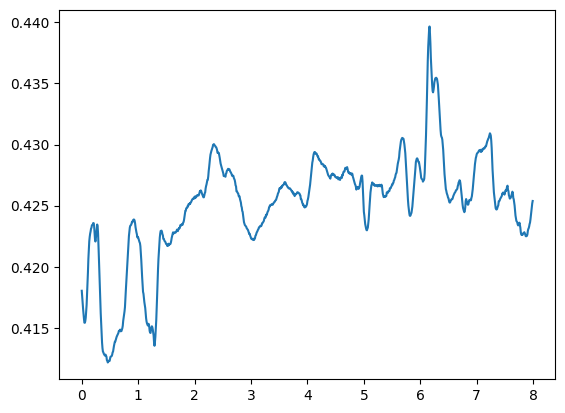

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(time_window, ppg_window_ir)
plt.show()

# **Check all classes**

In [ ]:
from sqis.calculation.imu import IMUDetector
from sqis.calculation.indices import SQIcalc
from sqis.calculation.fiducials import getFiducials
import ast

imu = IMUDetector(sampling_rate = ppg_fs, motion_threshold=0.2)
sqi = SQIcalc(sampling_rate=ppg_fs)
fid = getFiducials(sampling_rate=ppg_fs)

bad_motion, imu_metrics = imu.check_motion(acc_x_window, acc_y_window, acc_z_window)
if bad_motion:
    print("ABSTAIN - motion too high")
else:
    fid_dict = fid.extract_fiducials(ppg_window_ir)
    peaks            = fid_dict["systolic_peaks"]

    if len(peaks) > 1:
        # ... process diastolic peaks ...
        sqi_metrics = sqi.get_all_sqi(ppg_window_ir, peaks)
        print(f"SQIs: {sqi_metrics}")
    else:
        print("Skipping SQIs: Not enough peaks detected.")
    diastolic_peaks  = fid_dict["diastolic_peaks"]
    dicrotic_notches = fid_dict["notches"]
    pulse_onsets     = fid_dict["pulse_onsets"]
    
    
    

SQIs: {'template_correlation': np.float64(0.5900759727313981), 'skewness': np.float64(-0.7538409660630832), 'kurtosis': np.float64(1.5891794461295836), 'hjorth_activity': np.float64(2.0041046564373285e-05), 'hjorth_mobility': np.float64(0.0653836116027466), 'hjorth_complexity': np.float64(7.3988606578559235), 'spectral_entropy': np.float64(0.3986313708037382), 'spectral_snr': np.float64(0.5061583158144486)}


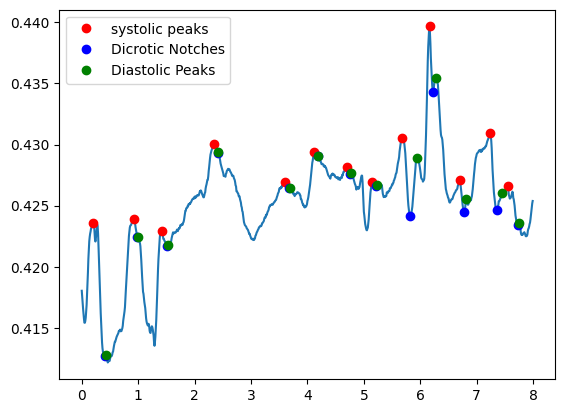

97.5


In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(time_window, ppg_window_ir)
plt.plot(time_window[peaks], ppg_window_ir[peaks], 'ro', label='systolic peaks')
plt.plot(time_window[dicrotic_notches], ppg_window_ir[dicrotic_notches], 'bo', label='Dicrotic Notches')
plt.plot(time_window[diastolic_peaks], ppg_window_ir[diastolic_peaks], 'go', label='Diastolic Peaks')
plt.legend()
plt.show()

beats = len(peaks)
hr = 60*(beats/sample_seconds)
print(hr)